# Broadband light curve parameter estimation assuming white noise 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import math as mt
import pandas as pd
import seaborn as sb

from IPython.html.widgets import Text, IntProgress, HBox, VBox, HTML
from pandas import HDFStore
from emcee import EnsembleSampler
from pyde.de import DiffEvol

from src.lpf_ww import LPFunction
from core import *

pb_filter_bb.name = 'white'

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Create a wrapper class for the parameter estimation 

We have two versions of the white light curve: one without masking of the spectrum and one with masking. 

In [3]:
class PE(object):
    def __init__(self, wfname, n_walkers=100, n_threads=4):
        df_aux = pd.read_hdf('results/light_curves.h5', 'aux')
        df_lc  = pd.read_hdf('results/light_curves.h5', wfname)
        msk = array(df_aux.bad_mask, dtype=np.bool)
        
        self.lpf = LPFunction(array(df_aux.mjd-56846+0.5)[msk], df_lc.white[msk], df_aux.airmass[msk], n_threads)
        self.de = DiffEvol(self.lpf, self.lpf.ps.bounds, n_walkers, maximize=True, C=0.85, F=0.25)
        self.sampler = EnsembleSampler(self.de.n_pop, self.lpf.ps.ndim, self.lpf) 
                              
        qc = self.lpf.lds.coeffs_qd()[0][0]
        self.de._population[:,8] = normal(qc[0], 0.05, size=n_walkers) 
        self.de._population[:,9] = normal(qc[1], 0.05, size=n_walkers)
                  
            
    def run_de(self, n_iter=250):
        wp = IntProgress(value=0, max=n_iter)
        wh = HTML(value='inf')
        wb = VBox(children=[wp,wh])
        display(wb)
        for i, p in enumerate(self.de(n_iter)):
            if i%25 == 0:
                wp.value += 25
                wh.value = 'DE maximum log posterior {:10.3f}'.format(-self.de.minimum_value)
            
            
    def run_mcmc(self, n_iter=2500, thin=50):
        pbar = IntProgress(max=n_iter)
        display(pbar)
        for i, c in enumerate(self.sampler.sample(self.de.population, iterations=n_iter, thin=thin)):
            if i%50 == 0:
                pbar.value += 50
                
                
    def create_dataframe(self, burn=0, thin=1):
        self.df = pd.DataFrame(self.fc(burn,thin), columns=self.lpf.ps.names)
        self.df['k'] = sqrt(self.df['k2'])
        return self.df     
                
        
    def fc(self, burn=0, thin=1):
        return self.chain[:,burn::thin,:].reshape([-1, self.chain.shape[2]])

    
    @property
    def chain(self):
        return self.sampler.chain

## Run the unmasked LC analysis 

In [4]:
pe_n = PE('final/bb_nomask')
pe_n.run_de(300)
pe_n.run_mcmc(10000)

In [5]:
pe_n.sampler.acor

array([  0.12636285,   3.88130186,  13.40492017,  13.12315159,
        13.6853396 ,          nan,  65.79406778,  13.19064758,
         2.09730068,   2.85905507])

In [ ]:
fig,ax = subplots(1,1)
ax.plot(pe_n.chain[:,20::20,0].T, 'k', alpha=0.1)
fig.tight_layout()

## Run the masked LC analysis 

In [ ]:
pe_m = PE('final/bb_masked')
pe_m.run_de(300)
pe_m.run_mcmc(10000)

In [8]:
pe_m.sampler.acor

array([-0.10259073,  3.05926741,  9.82984696,  9.86320502,  9.61606374,
        9.75760136,  1.74920736,  1.81361535,  3.02035148,  2.84708261])

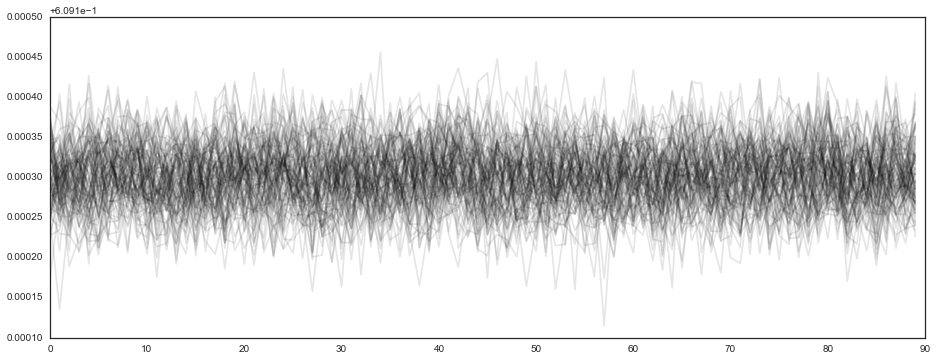

In [9]:
fig,ax = subplots(1,1)
ax.plot(pe_m.chain[:,20::2,0].T, 'k', alpha=0.1)
fig.tight_layout()

In [10]:
pe_m.chain[:,::,0].shape

(100, 200)

## Create and save the dataframes

In [11]:
dfn = pe_n.create_dataframe(20, 2)
dfm = pe_m.create_dataframe(20, 2)

In [12]:
hdf = HDFStore(join('results','pe.h5'))
hdf.put('bb/wn_nomask', dfn, format='table', data_columns=True)
hdf.put('bb/wn_masked', dfm, format='table', data_columns=True)
hdf.close()

## Plots 

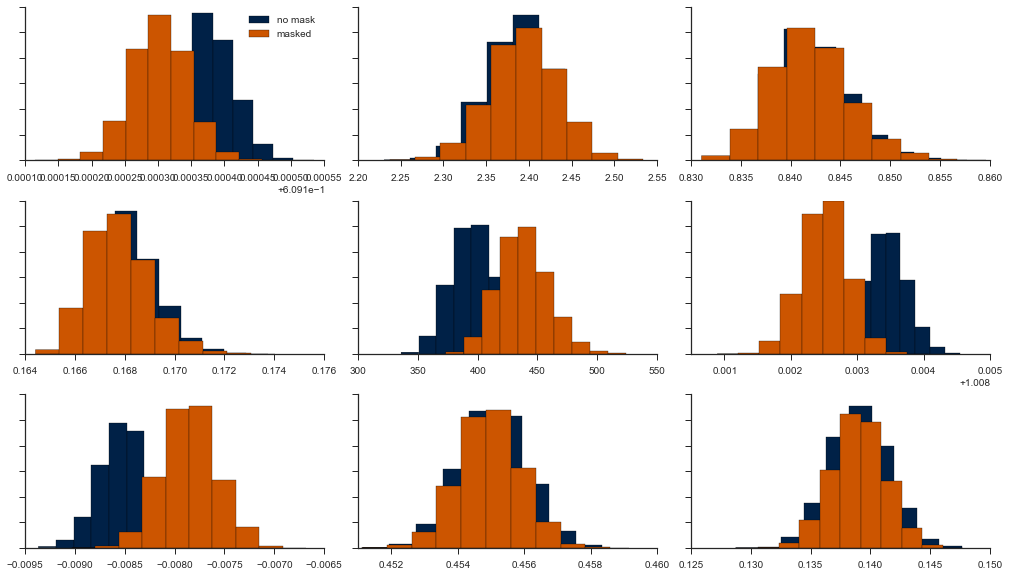

In [13]:
dfn['e_ppm'] = 1e6*dfn.e
dfm['e_ppm'] = 1e6*dfm.e

pars = 'tc rho b k e_ppm c x u v'.split()

with sb.axes_style('ticks'):
    fig,axs = subplots(3,3,figsize=(14,8))
    for i,p in enumerate(pars):
        dfn[p].hist(ax=axs.flat[i], fc=cp[0], label='no mask', grid=False)
        dfm[p].hist(ax=axs.flat[i], fc=cp[1], label='masked', grid=False)
        setp(axs.flat[i].get_yticklabels(), visible=False)
    axs.flat[0].legend()
    sb.despine(fig)
    fig.tight_layout()

---
<center> &copy; 2015 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>